### Notebook to make plots for catalog of FRBs
Jessie Thwaites, 9/28

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.time import Time
from matplotlib.gridspec import GridSpec

#import imp
#imp.reload(cat)
import catalogs_to_csv as cat
#import frb_catalog_plots as plot

<module 'catalogs_to_csv' from '/home/jthwaites/FRB/catalogs_to_csv.py'>

In [4]:
mpl.rcParams['font.size'] = 20
frbs=cat.load_frbs() #All combined FRB data previously put into a csv file

Loading all FRBs from catalogs


In [7]:
rep=np.where(frbs['repeater'])[0]
non_rep=np.where(frbs['repeater']==False)[0]

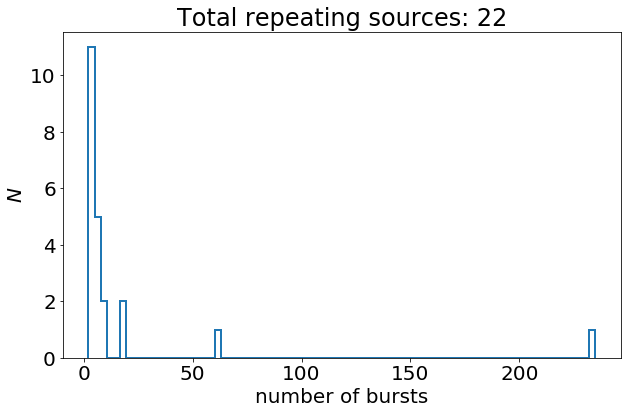

In [10]:
"""Histogram of number of bursts per repeater"""

unique_rep, counts=np.unique([frbs['src'][i] for i in rep], return_counts=True)
    
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(counts, histtype='step', lw=2., bins=80)
plt.xlabel('number of bursts')
plt.ylabel(r'$N$')
plt.title('Total repeating sources: %i'%len(unique_rep))
plt.savefig('/home/jthwaites/public_html/frb_param_plots/rep_bursts.png')

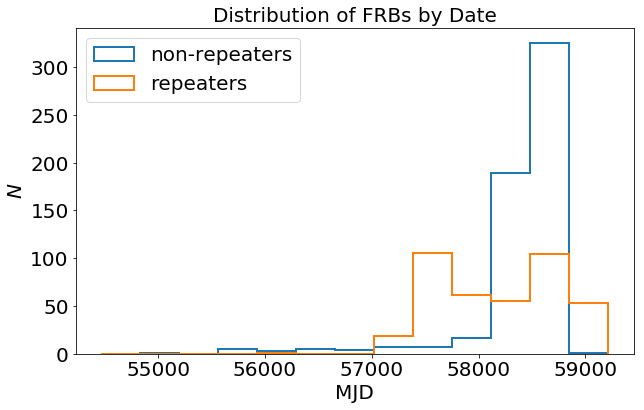

In [11]:
"""Histogram of number of FRBs discovered over time
Repeaters/non-repeater bursts seperated"""

year_bins = [Time(f'20{year:02d}-01-01 00:00:00', format='iso').mjd 
             for year in range(8, 22)]
fig, ax = plt.subplots(figsize=(10,6))
plt.hist([frbs['mjd'][i] for i in non_rep], bins=year_bins, histtype='step', lw=2., 
             label='non-repeaters')
plt.hist([frbs['mjd'][i] for i in rep], bins=year_bins, histtype='step', lw=2., 
             label='repeaters')

plt.legend(loc=2)
plt.xlabel('MJD')
plt.ylabel(r'$N$')
ax.set_title(r'Distribution of FRBs by Date', fontsize=20)
plt.savefig('/home/jthwaites/public_html/frb_param_plots/date_distr.png')

### Effective areas

In [4]:
# calculating effective area
def eff_area_gfu(n_cuts=2):
    mc = np.load('/data/ana/analyses/gfu/current/IC86_2011_MC.npy')
    nbins=28
    trueE_bins=np.logspace(2,9,num=nbins+1) #ow units: 1/(GeV cm^2 sr)
    bin_corr=(9.-2.)/nbins
    
    if n_cuts==2: #cuts pi->-5 and -5->-pi
        decmsk1=mc['trueDec']>(-5*np.pi/180)
        decmsk2=mc['trueDec']<=(-5*np.pi/180)

        cuts=[np.pi/2,-5*np.pi/180,-np.pi/2]
        dec_msks=[decmsk1,decmsk2]
        labels=[r'GFU, $\delta>-5$',r'GFU, $\delta<-5$']
        A_eff_w=[[],[]]
    
    if n_cuts==4: #finer cuts
        decmsk1=mc['trueDec']>(-5*np.pi/180)
        decmsk2=mc['trueDec']<(-5*np.pi/180)
        decmsk3=mc['trueDec']<(-30*np.pi/180)
        decmsk4=mc['trueDec']>(-30*np.pi/180)
        decmsk5=mc['trueDec']<(30*np.pi/180)
        decmsk6=mc['trueDec']>(30*np.pi/180)

        cuts=[np.pi/2,30*np.pi/180,-5*np.pi/180,-30*np.pi/180,-np.pi/2]
        dec_msks=[decmsk3,decmsk4&decmsk2,decmsk1&decmsk5,decmsk6]
        labels=[r'$-90<\delta<-30$',r'$-30<\delta<-5$',r'$-5<\delta<30$',r'$30<\delta<90$']
        A_eff_w=[[],[],[],[]]
    
    for a in range(len(dec_msks)):
        solid_ang=2*np.pi*(np.sin(cuts[a])-np.sin(cuts[a+1]))
        weight=mc['ow'][dec_msks[a]]/(mc['trueE'][dec_msks[a]]*solid_ang*bin_corr*1e4*np.log(10))
        for w in weight: A_eff_w[a].append(w)
    
    fig, ax = plt.subplots(figsize=(12,8))
    for i in range(len(cuts)-1):
        plt.hist(mc['trueE'][dec_msks[i]], bins=trueE_bins, weights=A_eff_w[i],
             histtype='step', lw=2., label=labels[i])
    plt.semilogx()
    plt.semilogy()
    plt.legend(loc=4)
    plt.xlabel(r'$E_\nu$ [GeV]')
    plt.ylabel(r'$A_{eff}$ [$m^2$]')
    ax.set_title(r'Effective area')
    plt.savefig('./frb_param_plots/effarea_gfu_%s.png'%(n_cuts))

# calc eff area and comparing to other datasets (PS Tracks and Transient Tracks)
def eff_area_comp():
    mpl.rcParams['font.size'] = 9
    
    mc = np.load('/data/ana/analyses/gfu/current/IC86_2011_MC.npy')
    mc_ps=np.load('/data/ana/analyses/ps_tracks/version-004-p00/IC86_2016_MC.npy')
    mc_tt=np.load(r'/data/ana/analyses/transient_tracks/version-001-p02/IC86_2011_North_nugen.npy')

    nbins=28
    trueE_bins=np.logspace(2,9,num=nbins+1) #ow units: 1/(GeV cm^2 sr)
    bin_corr=(9.-2.)/nbins
    
    #cuts pi->-5 and -5->-pi
    decmsk1=mc['trueDec']>(-5*np.pi/180) 
    decmsk2=mc['trueDec']<=(-5*np.pi/180)
    dec_msks=[decmsk1,decmsk2] #GFU
    
    decmsk3=mc_ps['trueDec']>(-5*np.pi/180) 
    decmsk4=mc_ps['trueDec']<=(-5*np.pi/180)
    dec_msksps=[decmsk3,decmsk4]#PS Tracks
    
    decmsk5=mc_tt['trueDec']>(-5*np.pi/180) 
    decmsk6=mc_tt['trueDec']<=(-5*np.pi/180)
    dec_mskstt=[decmsk5,decmsk6] #Transient tracks
    
    cuts=[np.pi/2,-5*np.pi/180,-np.pi/2]
    A_eff_w=[[],[]]
    A_eff_w2=[[],[]]
    A_eff_w3=[[],[]]
    labels=[r'GFU, dec$>-5$',r'GFU, dec$<-5$', 
            r'PS Tracks, dec$>-5$', r'PS Tracks, dec$<-5$', 
            r'Transient Tracks, $\delta>-5$', r'Transient Tracks, $\delta<-5$']
    
    for a in range(len(dec_msks)):
        solid_ang=2*np.pi*(np.sin(cuts[a])-np.sin(cuts[a+1]))
        weight=mc['ow'][dec_msks[a]]/(mc['trueE'][dec_msks[a]]*solid_ang*bin_corr*1e4*np.log(10))
        for w in weight: A_eff_w[a].append(w)
            
    for a in range(len(dec_msksps)):
        solid_ang=2*np.pi*(np.sin(cuts[a])-np.sin(cuts[a+1]))
        weight=mc_ps['ow'][dec_msksps[a]]/(mc_ps['trueE'][dec_msksps[a]]*solid_ang*bin_corr*1e4*np.log(10))
        for w in weight: A_eff_w2[a].append(w)
    
    for a in range(len(dec_mskstt)):
        solid_ang=2*np.pi*(np.sin(cuts[a])-np.sin(cuts[a+1]))
        weight=mc_tt['ow'][dec_mskstt[a]]/(mc_tt['trueE'][dec_mskstt[a]]*solid_ang*bin_corr*1e4*np.log(10))
        for w in weight: A_eff_w3[a].append(w)
    
    fig = plt.figure(dpi=200)
    gs = GridSpec(4,4)
    ax_effa = fig.add_subplot(gs[0:3,0:3])
    ax_ratio = fig.add_subplot(gs[3:4,0:3]) 
        
    ratio_xvals=[(trueE_bins[i+1]+trueE_bins[i])/2 for i in range(len(trueE_bins)-1)]
    for i in range(len(cuts)-1):
        h_ps=ax_effa.hist(mc_ps['trueE'][dec_msksps[i]], bins=trueE_bins, weights=A_eff_w2[i],
                          histtype='step', lw=1.,color='C%i'%(i+2), label=labels[i+2])
        #h_tt=ax_effa.hist(mc_tt['trueE'][dec_mskstt[i]], bins=trueE_bins, weights=A_eff_w3[i],
        #                  histtype='step', lw=1.,color='C%i'%(i+4), label=labels[i+4])
        h_gfu=ax_effa.hist(mc['trueE'][dec_msks[i]], bins=trueE_bins, weights=A_eff_w[i],
                           histtype='step', lw=1., color='C%i'%(i),label=labels[i])
        ax_ratio.plot(ratio_xvals, [h_ps[0][i]/h_gfu[0][i] for i in range(len(h_ps[0]))],
                         '.', color='C%i'%(i+2))
        #ax_ratio.plot(ratio_xvals, [h_tt[0][i]/h_gfu[0][i] for i in range(len(h_tt[0]))],
        #                 '.', color='C%i'%(i+4))
    ax_ratio.plot(ratio_xvals,[1]*len(ratio_xvals),'--',lw=0.5,color='black')
    
    plt.setp(ax_effa.get_xticklabels(), visible=False)
    ax_effa.set_yscale('log')
    ax_effa.set_xscale('log')
    ax_ratio.set_xscale('log')
    ax_effa.set_xlim([50,2e9])
    ax_ratio.set_xlim([50,2e9])

    ax_effa.set_ylabel(r'$A_{eff}$ [$m^2$]')
    ax_ratio.set_ylabel('Ratio:\n Dataset/GFU')
    ax_effa.legend(loc=4, fontsize=7)
    #ax_ratio.legend(loc=0, fontsize=5)
    ax_ratio.set_xlabel(r'$E_\nu$ [GeV]')
    ax_effa.set_title(r'Effective area')
    
    plt.savefig('/home/jthwaites/public_html/frb_param_plots/effarea_comp.png')
    #plt.savefig('./frb_param_plots/effarea_comp.png')

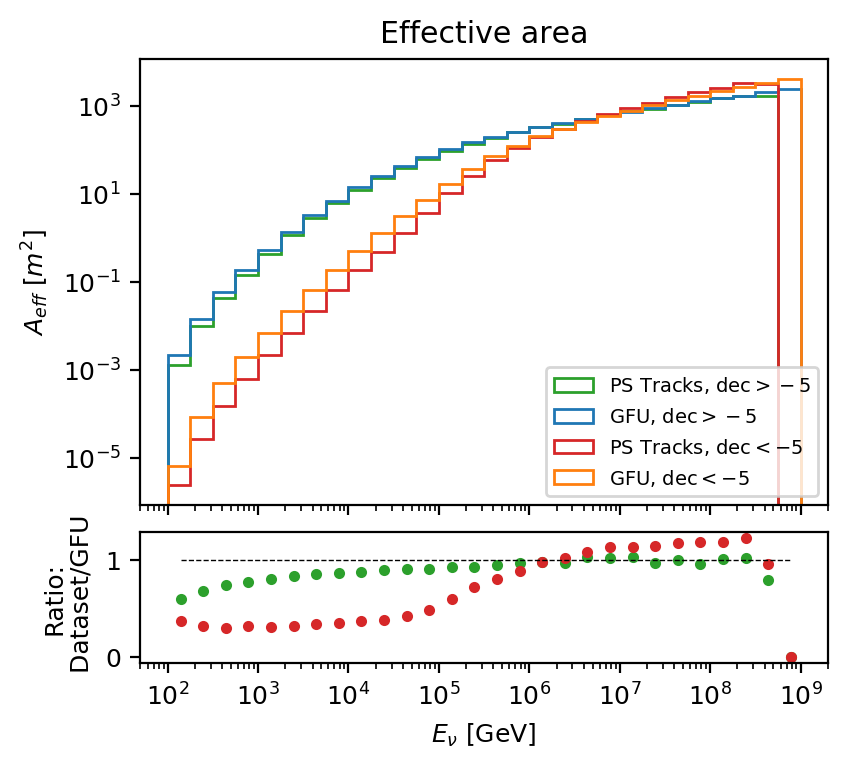

In [7]:
eff_area_comp()

In [75]:
"""Dec dist for FRB sources"""
cat.get_catalogs()
frbs=cat.load_frbs()

Loading all FRBs from catalogs


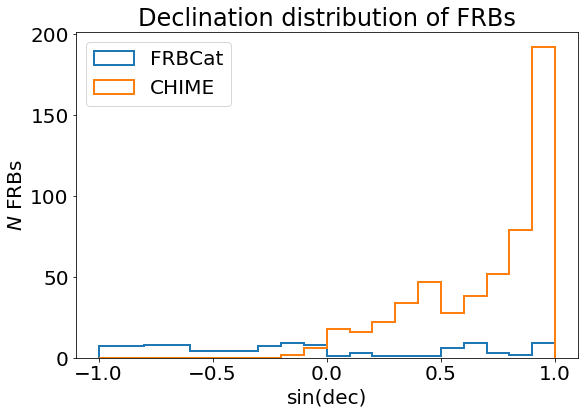

In [90]:
bins=np.linspace(-1.,1.,21)
fig, ax = plt.subplots(figsize=(9,6))

unique_srcs, unique_index=np.unique(frbs['src'],return_index=True)
repeats=[]
for i in range(len(frbs['src'])):
    if i not in unique_index: repeats.append(i)
#frbs=frbs.drop(repeats)
chime_cat1=np.where(frbs['catalog']=='CHIME_1')[0]
frbcat=np.where(frbs['catalog']=='FRBCat')[0]

plt.hist(np.sin(np.radians(frbs['dec_deg'][frbcat].values)), bins=bins, histtype='step', lw=2., label='FRBCat')
plt.hist(np.sin(np.radians(frbs['dec_deg'][chime_cat1].values)), bins=bins, histtype='step', lw=2., label='CHIME')

plt.xlabel(r'sin(dec)')
plt.ylabel(r'$N$ FRBs')
plt.legend(loc=2)
ax.set_title(r'Declination distribution of FRBs')
plt.savefig('/home/jthwaites/public_html/frb_param_plots/frbs_dec_dist.png')

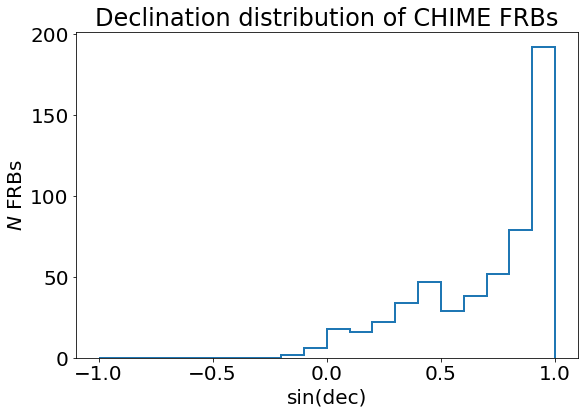

In [86]:
fig, ax = plt.subplots(figsize=(9,6))

chime_cat1 = pd.read_csv('./catalog/chimefrbcat1.csv')
remove_subburst=[]
for i in range(len(chime_cat1)):
    if chime_cat1['sub_num'].values[i]!=0: remove_subburst.append(i)
chime_cat1=chime_cat1.drop(remove_subburst)
chime_cat1_dec=chime_cat1['dec'].values


plt.hist(np.sin(np.radians(chime_cat1_dec)), bins=bins, histtype='step', lw=2.)

plt.xlabel(r'sin(dec)')
plt.ylabel(r'$N$ FRBs')
ax.set_title(r'Declination distribution of CHIME FRBs')
plt.savefig('/home/jthwaites/public_html/frb_param_plots/chime_dec_dist.png')

In [26]:
import setup

Setting up Analysis for:
GFU_for_2011_2012_2013_2014_2015_2016_2017_2018_2019
Setting up GFU_for_2011_2012_2013_2014_2015_2016_2017_2018_2019...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2011_MC.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2015_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2016_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2017_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2018_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2019_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/GRL/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/GRL/IC86_2012_data.npy ...
Reading /

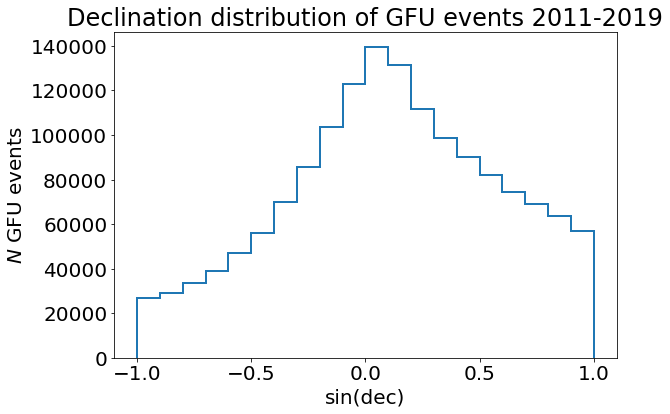

In [40]:
import csky as cy
a=cy.CONF['ana'][-1]
gfu_decs=a.data.dec

fig, ax = plt.subplots(figsize=(9,6))
plt.hist(np.sin(gfu_decs), bins=bins, histtype='step', lw=2.)

plt.xlabel(r'sin(dec)')
plt.ylabel(r'$N$ GFU events')
ax.set_title(r'Declination distribution of GFU events 2011-2019')
plt.savefig('/home/jthwaites/public_html/frb_param_plots/gfu_dec_dist.png')